# Exploration 5. 인물사진을 만들어보자 (semantic segmentation)

## 개요
 하나의 카메라로 Shallow Focus를 만드는 프로젝트입니다.  
먼저 이미지 세그멘테이션(image segmentation) 기술을 이용하여 하나의 이미지에서 배경과 사람을 분리합니다.  
분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하여 아웃포커싱 효과를 적용한 인물 사진을 만들어보겠습니다.  

## 목차
1. 사진 준비하기
	- 라이브러리 import
	- 이미지 읽어오기
2. Segmentation으로 사람 분리하기
	- PixelLib에서 제공해주는 모델을 다운로드하기
	- 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
	- 모델에 이미지 입력
	- 데이터의 라벨 종류 확인하기 : output, segvalues 확인
	- 컬러맵 만들기 : 컬러맵에서 원하는 라벨(대상의 라벨)의 배열 출력 
3. Semantic Segmentation 다뤄보기
    - 색상(채널) 순서 바꿔주기
    - seg_color로만 이루어진 마스크 만들기
    - 세그멘테이션이 잘 되었는지 확인
4. 배경 흐리게 하기
	- blur()함수로 전체 이미지 흐리게 만들기 (블러 처리)
5. 흐린 배경과 원본 영상 합성
	- 블러 배경만 추출 -> 원본 이미지의 대상(사람)과 합치기 


## 회고

## Reference


---

## 1. 사진 준비하기
### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
![shallow focus](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-2.max-800x600_jKvxGUl.png)  

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다.   
이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다.   
분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.  

따라서 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들겠습니다.  

1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)  
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.  
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.  
4. 피사체를 배경의 원래 위치에 합성합니다.   

사용할 디렉터리 구조는 아래와 같습니다.

In [3]:
# - aiffel/human_segmentation
#     ├── models
#         └── deeplabv3_xception_tf_dim_ordering_tf_kernels.h5 (미리 준비할 필요는 없습니다)
#     ├── images
#         └── my_image.png

### 라이브러리 import  
- urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요합니다.
- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리인데요. 아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용만 해봅니다.

In [4]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


### 준비한 이미지를 읽기

(500, 892, 3)


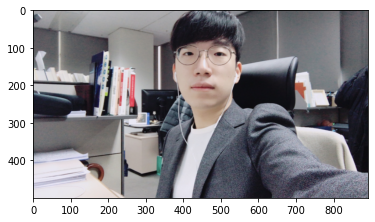

In [5]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Segmentation으로 사람 분리하기
배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 합니다.   
흔히 포토샵으로 '누끼 따기'라는 것이 바로 이런 작업을 말합니다. 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업이지요.  

![누끼따기](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-4.max-800x600_9yTzEff.png)

### 세그멘테이션(Segmentation)이란?  
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고, 라벨이 같은 객체들은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.  

- 시맨틱 세그멘테이션(semantic segmentation)이란?  
세그멘테이션 중에서도 특히, 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법입니다.
- 인스턴스 세그멘테이션(Instance segmentation)이란?  
![인스턴스 세그멘테이션](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png)  
시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.  
더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.  

Q. 인스턴스 세그멘테이션 데이터셋과 라벨이 존재하면 시맨틱 세그멘테이션을 학습시킬 수 있을까요?  
인스턴스의 id 뿐만이 아닌 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능합니다. 근본적으로는 다른 개념이지만 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재합니다.  

### 딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?
- 워터쉐드 세그멘테이션(watershed segmentation)  
이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 그럼 경계는 어떻게 나눌 수 있을까요?  
이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.  
자세한 내용은 opencv-python tutorial에서 확인할 수 있습니다.

## 3. Semantic Segmentation 다뤄보기


본격적으로 세그멘테이션을 다루어 보겠습니다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용해 볼 건데요. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.  

오늘은 네트워크에 대한 자세한 내용보다 세그멘테이션의 활용 방법 위주로 다루겠습니다.  

DeepLab에 대한 자세한 설명은 아래 링크를 참고해 주세요.  
- [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://bloglunit.wordpress.com/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)
![DeepLab V3+](https://bloglunit.files.wordpress.com/2018/07/deeplabv3plus_detail.png)  
- Xception 기반의 encoder로 양질의 high level semantic 정보를 가지는 feature를 추출할 수 있고, 
- ASPP 모듈을 통해 각 픽셀이 여러 스케일의 context 정보를 취해 보다 정확한 추론이 가능하며, 
- U-Net 구조의 decoder를 통해 각 물체에 해당하는 정교한 boundary를 그려낼 수 있기에  
상당히 안정적이고 정확하게 각각의 픽셀에 대해 클래스를 예측하는 Visualization 결과를 얻을 수 있습니다.

Q. DeepLab에서 atrous convolution을 사용한 이유가 무엇인가요?  
A. receptive field를 넓게 사용하기 위해 사용합니다. (적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해)  

Q. Depthwise separable convolution은 어디서 처음 사용한 것 일까요? 왜 이 구조가 효율적일까요?  
A. Xception 에서 제안되었습니다. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적입니다.  


- 참고자료 : [Xception 더 알아보기](https://arxiv.org/abs/1610.02357)

DeepLab 모델을 준비하겠습니다. 아까 준비한 PixelLib를 이용하면 편하게 사용할 수 있습니다.  
- [PixelLib](https://github.com/ayoolaolafenwa/PixelLib)  

### PixelLib에서 제공해주는 모델을 다운로드하기

In [6]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 
# model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장

# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) 
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장


# model_url 부연 설명 : 
# 이 모델은 PixelLib 라이브러리의 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 파일에 위치해 있습니다.
# 해당 URL은 GitHub 저장소에서 모델 파일을 다운로드 받을 수 있는 주소입니다. 
# 일반적으로 이러한 모델 파일은 딥 러닝 모델을 미리 학습시켜 놓은 가중치(weights)를 포함하고 있으며, 
# 이를 활용하여 다양한 작업에 모델을 적용할 수 있습니다.

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f33e6ae70a0>)

### 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

In [7]:
#PixelLib 라이브러리에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만들기
model = semantic_segmentation() 

# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 

- model.load_pascalvoc_model(model_file):   
생성된 모델 인스턴스에 대해, 'model_file'에 지정된 Pascal VOC 데이터셋으로 미리 훈련된 가중치(weights)를 로드합니다. 이러한 가중치는 이미지의 시맨틱 세그멘테이션 작업을 위해 사전에 학습된 모델의 파라미터를 포함합니다.

### 모델에 이미지 입력하기

In [8]:
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용

- 분할된 이미지의 배열은 'output'에 저장되고, 해당 분할의 세그멘테이션 값은 'segvalues'에 저장됩니다.   
- 이때, 'segmentAsPascalvoc' 메서드는 Pascal VOC 데이터셋으로 학습된 모델을 사용하여 세그멘테이션을 수행합니다.  
모델마다 학습시킨 데이터에 따라 결과값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.  

[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)  

PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

### 데이터의 라벨 종류 확인하기

In [9]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 됩니다! (인덱스는 0부터 시작하므로)  
이 중 **사람(person) 라벨, 즉 15를 가진 영역만 검출**하고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살펴보겠습니다.

#### output 확인

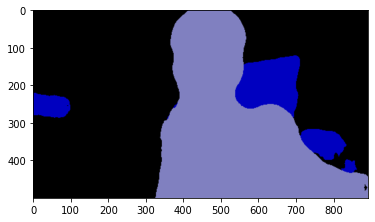

In [10]:
#segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

#### segvalues (세그멘테이션 값) 확인

In [11]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [12]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


- output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있습니다.  
- segvalues에는 class_ids와 masks가 있습니다. 
- class_ids로 어떤 물체가 담겨 있는지 확인


### 컬러맵 만들기
**물체마다 output에 어떤 색상으로 나타나 있는지** 알아낼 때는 컬러맵을 활용합니다.  
컬러맵(Color Map 또는 Colormap)은 이미지에서 픽셀 값에 대응되는 색상을 정의하는 방법입니다.   
주로 픽셀 값은 그레이스케일 이미지에서는 밝기를 나타내며, 컬러 이미지에서는 색상을 나타냅니다.   
컬러맵은 시각적인 정보를 전달하거나 특정 값의 패턴을 강조하는 데 사용됩니다.

In [13]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

> - colormap이라는 256x3 크기의 배열을 생성합니다. 각 행은 RGB 값으로 표현된 색상을 나타냅니다.
> - ind는 0부터 255까지의 정수를 담은 배열입니다.

PixelLib에 따르면 위와 같은 색을 사용했다고 합니다. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [14]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

colormap[15] 

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있습니다.  


### 색상(채널) 순서 바꿔주기
여기서 주의할 것은 **output 이미지가 BGR 순서로 채널 배치가 되어 있다**는 점입니다.   
**colormap은 RGB 순서**이므로 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 합니다.

In [15]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (128,128,192) 

### seg_color로만 이루어진 마스크를 만들어보기

(500, 892)


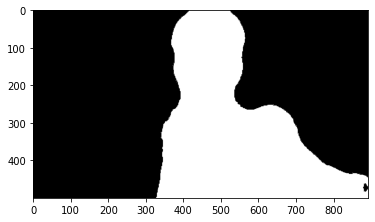

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
# seg_color 값이 person 값이므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# seg_map = np.all(output == seg_color, axis=-1)를 사용하여 세그멘테이션 결과에서 지정된 색상과 일치하는 픽셀을 찾아 seg_map에 저장
# axis=-1는 NumPy 배열에서 연산을 수행할 때, 마지막 축을 기준으로 연산을 진행하라는 의미.

- output 배열은 이미지의 세그멘테이션 결과를 나타냅니다. 이 코드에서는 특정 색상인 seg_color와 일치하는 픽셀을 찾기 위해 np.all 함수를 사용합니다.
- axis=-1는 마지막 차원(여기서는 채널)을 기준으로 모든 조건을 만족해야 하는지를 나타내며, 이를 통해 RGB 색상에 대한 일치 여부를 확인합니다.
- 결과로 생성된 seg_map은 불리언 형태의 배열로, True는 해당 픽셀이 seg_color와 일치함을 나타냅니다.

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.  

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

In [17]:
# [
# [ 0 1 1 0 0 0 1 1 0 ],
# [ 1 1 1 1 0 1 1 1 1 ],
# [ 0 1 1 1 1 1 1 1 0 ],
# [ 0 0 1 1 1 1 1 0 0 ],
# [ 0 0 0 1 1 1 0 0 0 ]
# ]

### 세그멘테이션이 얼마나 잘 되었는지 확인하기
사람과 배경을 분리해서 표현한 color_mask를 만들어 원본 이미지 위에 color_mask를 합쳐서 출력합니다.

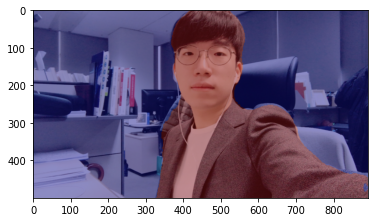

In [18]:
# 원본 이미지를 img_show에 할당한 뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든 뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- cv2.addWeighted 함수를 사용하여 원본 이미지(img_show)와 적용된 색상 맵(color_mask)을 일정한 비율로 혼합합니다.   
세 개의 파라미터는 각각 (입력 이미지1, 가중치1, 입력 이미지2, 가중치2, 가중치 적용 후 추가되는 값)을 나타냅니다.   
이를 통해 세그멘테이션 결과를 원본 이미지 위에 시각적으로 나타냅니다.  
- cv2.cvtColor를 사용하여 BGR 포맷을 RGB 포맷으로 변환한 후 Matplotlib을 이용해 이미지를 출력

## 4. 배경 흐리게 하기


### blur() 함수를 이용하여 배경을 흐리게 만들기

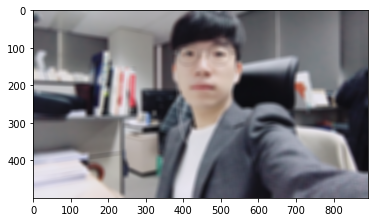

In [19]:
img_orig_blur = cv2.blur(img_orig, (13,13)) # (13,13)은 blurring kernel size - 다양하게 바꿔보기

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

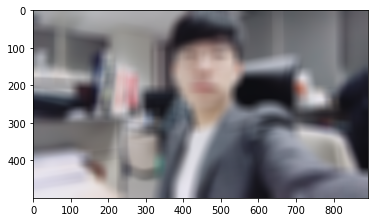

In [20]:
# kernel size (30, 30)
img_orig_blur = cv2.blur(img_orig, (30,30))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

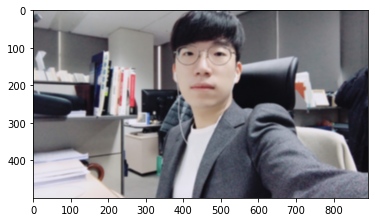

In [21]:
# kernel size (5, 5)
img_orig_blur = cv2.blur(img_orig, (5,5))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

> 커널 사이즈가 클수록 블러효과가 커진다.

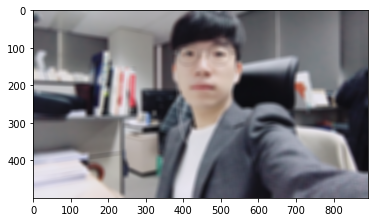

In [22]:
# kernel size (13, 13)
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

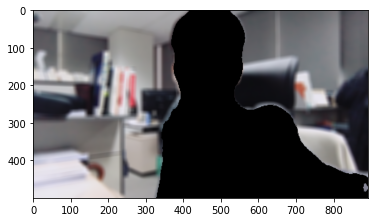

In [23]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나, 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 블러 배경만 얻기
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.bitwise_and()을 활용하여 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 결국 사람이 사라지고 배경만 남습니다!

## 5. 흐린 배경과 원본 영상 합성
### 배경 영상과 사람 영상을 합치기

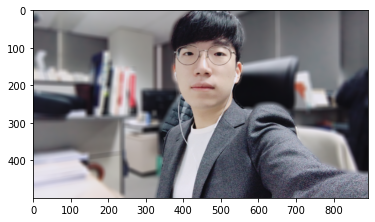

In [24]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255 , img_orig, img_bg_blur)
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

- [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

인물 사진이 만들어졌습니다.  
인물과 배경의 거리 차이가 있고 거리가 일정할수록 더 자연스러워 보입니다!  

- Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
- 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.

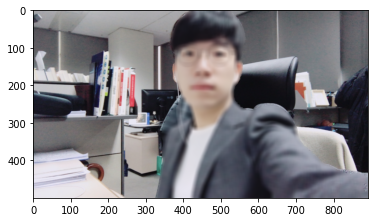

In [25]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color > 0, img_orig_blur, img_orig)
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

---

## 회고
각 인스턴스 별 역할이 무엇인지 빠르게 캐치되지 않아 원하는 조건으로 바꾸고 싶을 때 혼란스럽고 어렵다.   
모든 인스턴스를 다 기억하려고 하기 보다는
- 각 단계에서 어떤 작업을 했고
- 내가 필요한 인스턴스가 무엇인지를 파악   

하는 연습을 해야겠다.

---

## Reference
- [matplotlib - plt.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
- [matplotlib - plt.show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html)